In [2]:
import requests
import numpy as np
import matplotlib.pyplot as plt


In [3]:
payload = {'smiles': 'COCC'}
response = requests.post('http://localhost:8091/BE', json=payload)

In [30]:
FILE = 'temp.mol'
with open(FILE, 'r+') as f:
    content = f.readlines()
print(content)
content = ''.join(content)

payload = {'molfile' : content}
print(payload)

response = requests.post('http://localhost:8091/v1/MolfileToSpectrum', json=payload).json()
print(response)

['\n', '     RDKit          3D\n', '\n', '  8  7  0  0  0  0  0  0  0  0999 V2000\n', '   -0.7533   -0.0093    0.0601 C   0  0  0  0  0  0  0  0  0  0  0  0\n', '    0.7504   -0.0263    0.0011 C   0  0  0  0  0  0  0  0  0  0  0  0\n', '   -1.1589    0.1177    1.0753 H   0  0  0  0  0  0  0  0  0  0  0  0\n', '   -1.0772    0.8427   -0.5977 H   0  0  0  0  0  0  0  0  0  0  0  0\n', '   -1.1758   -0.9182   -0.4328 H   0  0  0  0  0  0  0  0  0  0  0  0\n', '    1.0733   -0.5749   -0.9198 H   0  0  0  0  0  0  0  0  0  0  0  0\n', '    1.2143   -0.4556    0.9130 H   0  0  0  0  0  0  0  0  0  0  0  0\n', '    1.1271    1.0239   -0.0993 H   0  0  0  0  0  0  0  0  0  0  0  0\n', '  1  2  1  0\n', '  1  3  1  0\n', '  1  4  1  0\n', '  1  5  1  0\n', '  2  6  1  0\n', '  2  7  1  0\n', '  2  8  1  0\n', 'M  END\n']
{'molfile': '\n     RDKit          3D\n\n  8  7  0  0  0  0  0  0  0  0999 V2000\n   -0.7533   -0.0093    0.0601 C   0  0  0  0  0  0  0  0  0  0  0  0\n    0.7504   -0.0263   

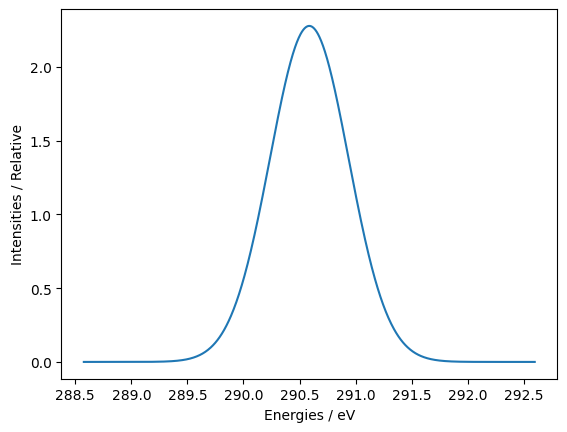

In [31]:
def plot_spectrum(json_response):
    fig, ax = plt.subplots(1,1)
    spectrum = json_response['spectrum']
    x, y = spectrum['x'], spectrum['y']
    ax.plot(x['data'], y['data'])
    ax.set_xlabel(f"{x['label']} / {x['units']}")
    ax.set_ylabel(f"{y['label']} / {y['units']}")
plot_spectrum(response)

In [ ]:
def plot_val(values, sigma, plot = True):
    def g(BE_sweep, BE_max, σ):
        G = 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-(BE_sweep-BE_max)**2 / (2*sigma**2))
        new_y= np.array(G)
        return new_y

    # Calculate mean and standard deviation
    mean = np.mean(values)
    std_dev = np.std(values)
    # Create a range of x values for the plot
    x = np.linspace(min(values) - 2, max(values) + 2, 1000)

    # Plot Gaussian curves for each center value
    #plt.figure(figsize=(8, 6))
    gaussian=0
    for val in values:
        gaussian += g(x,val,sigma)
    return x, gaussian

x,y = plot_val(BEs, 0.35)

(289.0, 294.0)

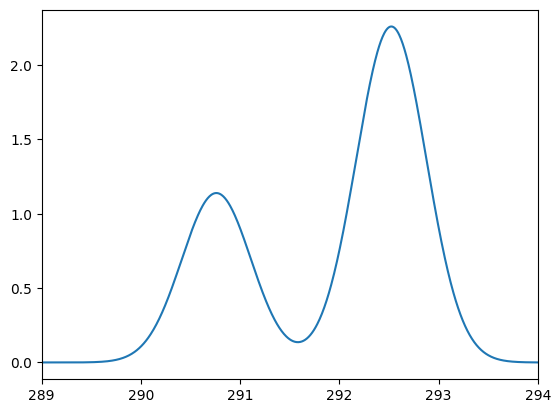

In [ ]:
plt.plot(x,y)
plt.xlim(289, 294)